# Mahalanobis Distance Filter for Quality Control

### Table of Contents
#### [Mahalanobis Distance Filter for Quality Control](#Mahalanobis-Distance-Filter-for-Quality-Control)
#### [Imports and Modules](#Imports-and-Modules)
#### [Sample Data](#Sample-Data)
#### [Data Processing and Visualization using seaborn](#Data-Processing-and-Visualization-using-seaborn)
#### [Mahalanobis Distance Outlier Detection](#Mahalanobis-Distance-Outlier-Detection)
#### [Filtered Plot Function](#Filtered-Plot-Function)

# Imports and Modules

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
import seaborn as sns
from matplotlib.patches import Ellipse
from typing import Tuple
import warnings

warnings.filterwarnings("ignore")
print("Setup Complete")

Setup Complete


# Sample Data

In [37]:
# Read csv
csv_path = "data/sample_data_7d.csv"
df_sample = pd.read_csv(csv_path)
df_sample.head()

,Pile No.,Sample 1,Sample 2,Sample 3
0,23,4170,4020,4080
1,17,4080,4210,4030
2,27,4400,4080,4730
3,63,4320,4100,4100
4,30,4330,4120,4250


# Data Processing and Visualization using seaborn

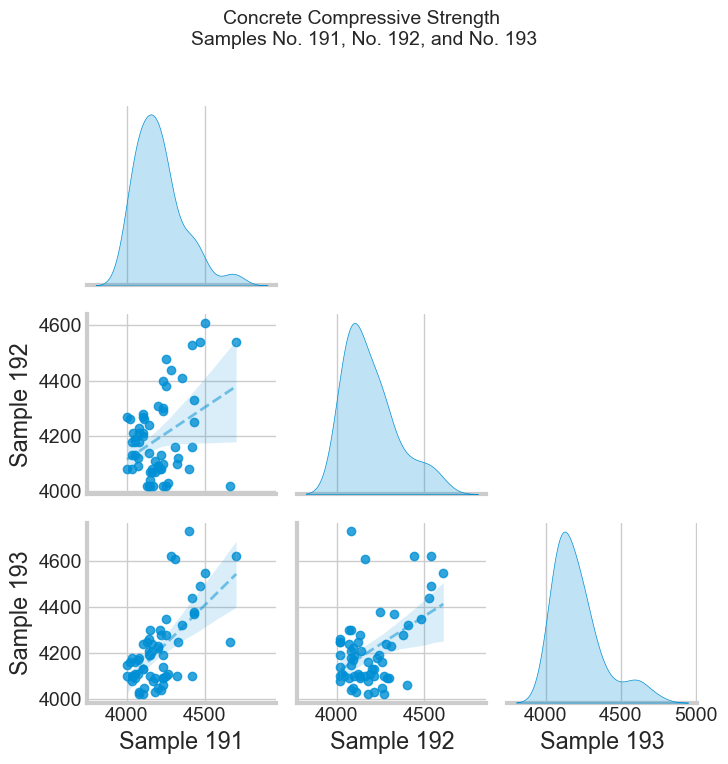

In [38]:
def process_data(data):
    """
    Processes raw data into a format suitable for plotting.
    Takes measurements from Sample 1, Sample 2, and Sample 3 and returns them as a DataFrame.

    Args:
        data: DataFrame containing Sample 1, Sample 2, and Sample 3 columns

    Returns:
        DataFrame with Sample 191, Sample 192, and Sample 193 columns containing valid triplets
    """
    processed_data = []
    for _, row in data.iterrows():
        # Only include rows where all samples have valid measurements
        sample1 = row["Sample 1"] if not pd.isna(row["Sample 1"]) else None
        sample2 = row["Sample 2"] if not pd.isna(row["Sample 2"]) else None
        sample3 = row["Sample 3"] if not pd.isna(row["Sample 3"]) else None
        if all(pd.notna([sample1, sample2, sample3])):
            processed_data.append(
                {
                    "Sample 191": sample1,
                    "Sample 192": sample2,
                    "Sample 193": sample3,
                }
            )
    return pd.DataFrame(processed_data)


# ===== Plotting Functions =====


def create_pair_plot(data, save_graph=False):
    """
    Creates a pair plot comparing compressive strength measurements between three samples.
    Includes regression lines and statistical information.

    Args:
        data: DataFrame with Sample 191, Sample 192, and Sample 193 columns

    Returns:
        seaborn PairGrid object containing the plots
    """
    # Set up the plot style
    sns.set_style("whitegrid")

    # Create pair plot
    pair_plot = sns.pairplot(
        data,
        kind="reg",
        plot_kws={"line_kws": {"linestyle": "--", "linewidth": 2, "alpha": 0.5}},
        diag_kind="kde",
        diag_kws={"shade": True},
        corner=True,
    )

    # Add title
    pair_plot.figure.suptitle(
        "Concrete Compressive Strength \nSamples No. 191, No. 192, and No. 193",
        fontsize=14,
        y=1.02,
    )

    # Save graph
    if save_graph:
        pair_plot.savefig(
            "images/concrete_strength_pairplot.png", dpi=300, bbox_inches="tight"
        )
    plt.tight_layout()
    return pair_plot


# Run main
if __name__ == "__main__":
    # Process the raw data
    data = df_sample
    processed_data = process_data(data)

    # Create and display the pair plot
    pair_plot = create_pair_plot(processed_data)

# Mahalanobis Distance Outlier Detection

## MahalanobisFilter

In [39]:
class MahalanobisFilter:
    """Detects outliers using Mahalanobis distance."""

    def __init__(self, alpha: float = 0.05):
        """Initialize with significance level alpha (default 0.05)"""
        self.alpha = alpha

    def fit(self, X: pd.DataFrame):
        """Calculate mean and inverse covariance matrix from data"""
        # Exclude 'Pile No.' from calculations if it exists
        self.data_columns = X.columns.difference(["Pile No."])
        self.mean = np.mean(X[self.data_columns], axis=0)
        self.cov = np.cov(X[self.data_columns], rowvar=False)
        self.inv_cov = np.linalg.inv(self.cov)

    def mahalanobis_distance(self, x: pd.Series) -> float:
        """Calculate Mahalanobis distance for a single point"""
        # Ensure x is aligned with self.data_columns
        x = x[self.data_columns]
        return mahalanobis(x, self.mean, self.inv_cov)

    def filter(
        self, X: pd.DataFrame, margin: float = 1e-5
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Filter data into inliers and outliers based on Mahalanobis distance
        relative to a three-sigma threshold.
        Returns (inliers, outliers) as DataFrames.
        """
        # Calculate distances and three-sigma threshold
        distances = np.array(
            [self.mahalanobis_distance(X.iloc[i]) for i in range(len(X))]
        )
        threshold_distance = (
            np.sqrt(chi2.ppf(0.997, df=len(self.data_columns))) + margin
        )  # 3-sigma threshold with margin

        # Split data
        inlier_indices = distances <= threshold_distance
        outlier_indices = distances > threshold_distance

        return X[inlier_indices], X[outlier_indices]

## Data Processing

In [40]:
# Process Data
def process_data(data: pd.DataFrame, sample_pairs: tuple) -> pd.DataFrame:
    """Extract and pair non-null samples from raw data.

    Args:
        data: Input DataFrame containing sample data
        sample_pairs: Tuple of column names to pair

    Returns:
        DataFrame containing only complete pairs of samples
    """
    # Include 'Pile No.' if it exists
    columns_to_select = (
        ["Pile No."] + list(sample_pairs)
        if "Pile No." in data.columns
        else list(sample_pairs)
    )

    df = (
        data.loc[:, columns_to_select]  # Select only the necessary columns
        .dropna()  # Remove rows with any null values
        .copy()  # Return a copy to avoid SettingWithCopyWarning
    )
    return df

## Visualization

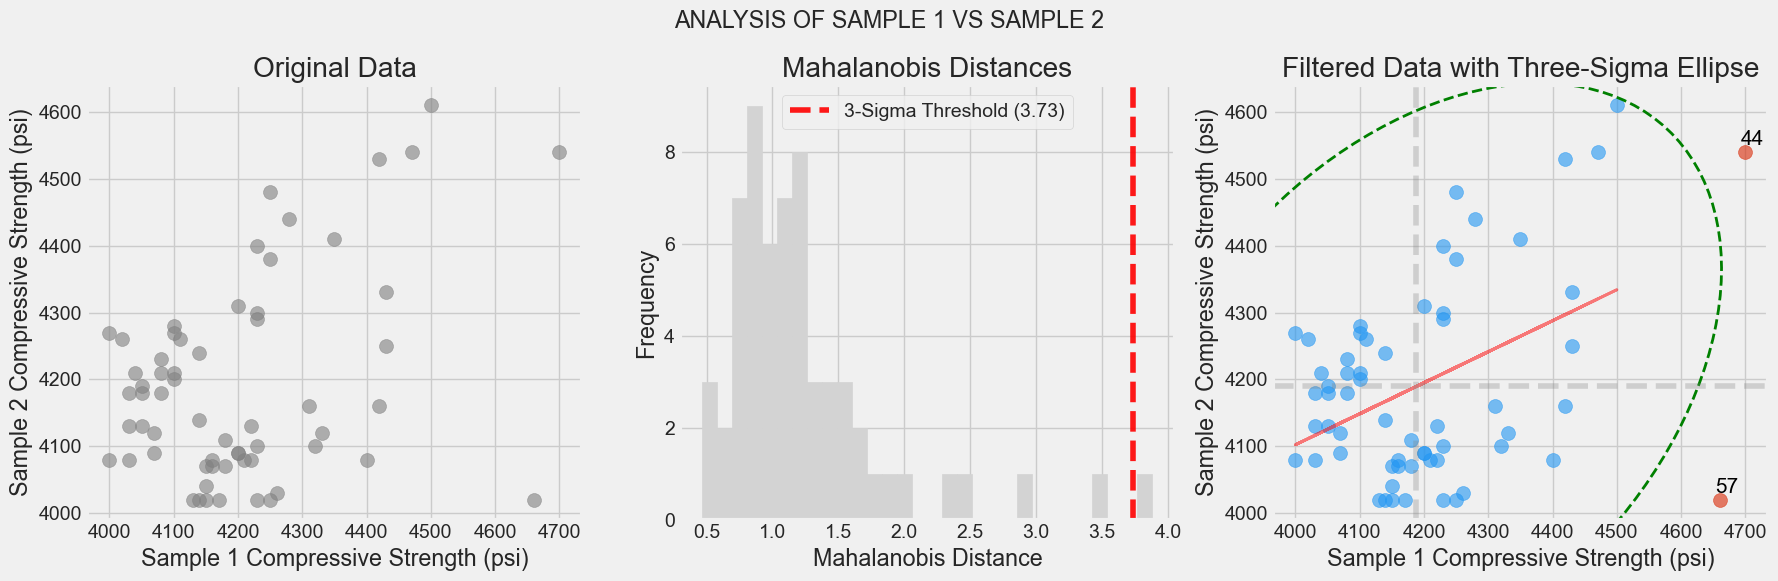

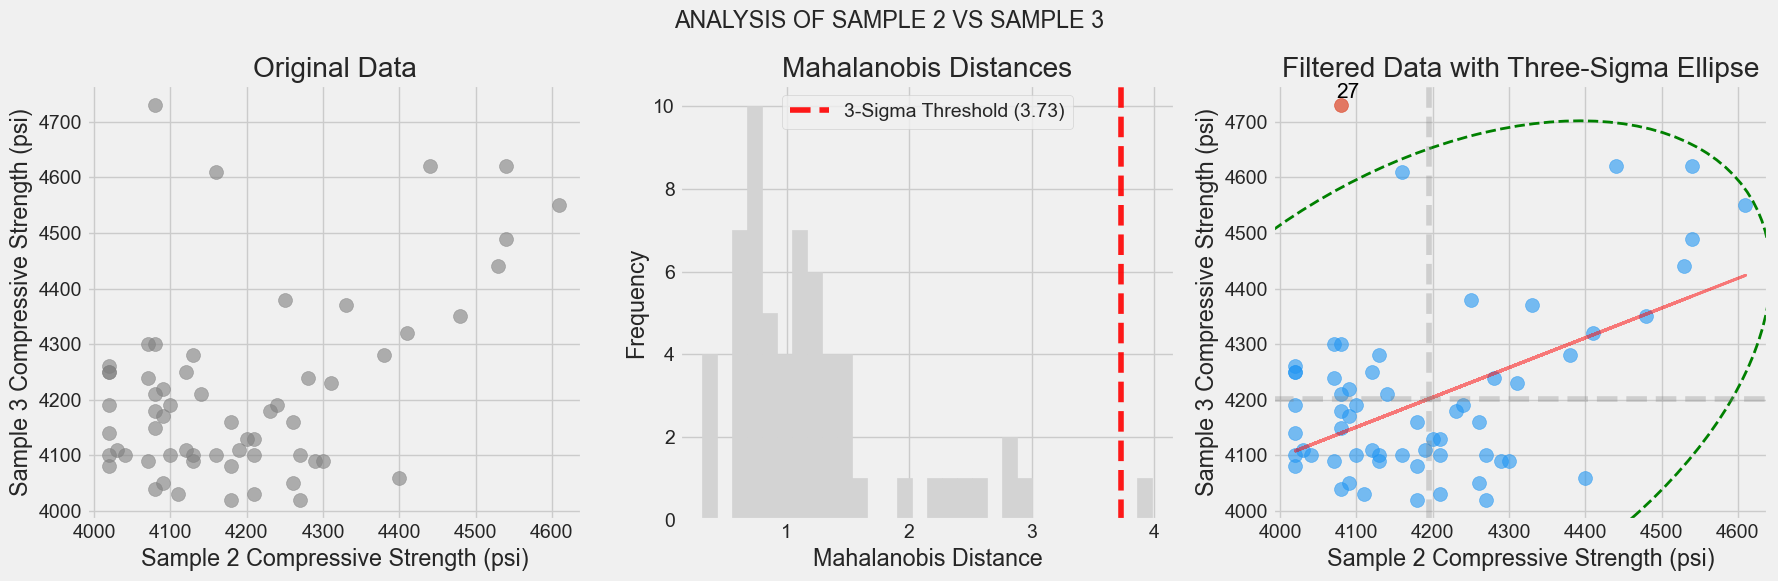

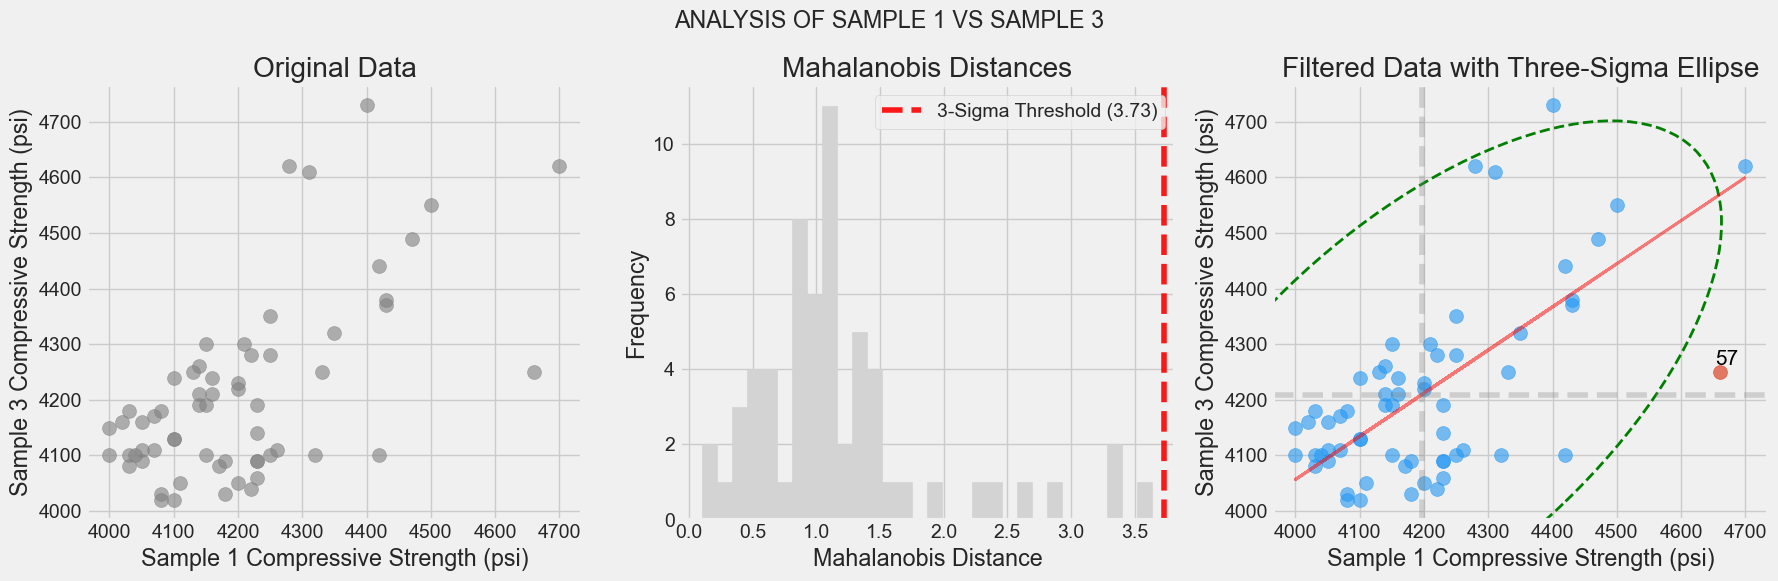

In [41]:
# Plot Ellipse
def plot_ellipse(
    mean: np.ndarray,
    cov: np.ndarray,
    ax: plt.Axes = None,
    n_std: float = 3.0,
    facecolor: str = "none",
    **kwargs,
) -> None:
    """
    Plot an n-standard deviation ellipse based on a 2D Gaussian distribution.

    Parameters:
        mean (array-like): The mean vector of the distribution (2,)
        cov (array-like): The covariance matrix of the distribution (2, 2)
        ax (matplotlib.axes.Axes, optional): The axis to plot the ellipse on. Defaults to None.
        n_std (float, optional): The number of standard deviations to determine the ellipse's radius. Defaults to 3.0.
        # The default value of 3 for the `n_std` parameter in the context of plotting a confidence ellipse 
            # is commonly used because it corresponds to a 99.7% confidence interval in a normal distribution. 
        # This is based on the empirical rule, which states that:
        # - Approximately 68% of the data falls within 1 standard deviation,
        # - About 95% falls within 2 standard deviations,
        # - And about 99.7% falls within 3 standard deviations.
        # Therefore, using n_std=3 provides a visual representation of the region where we expect 
        # the majority of the data points to lie, assuming a normal distribution.
        # This choice of n_std is a common convention in statistical visualizations, 
        # but it can be adjusted based on the specific requirements of the analysis.
        facecolor (str, optional): Color inside the ellipse. Defaults to "none".
        kwargs: Additional keyword arguments for the Ellipse patch
    """
    ax = plt.gca() if ax is None else ax

    mean = np.array(mean) if not isinstance(mean, np.ndarray) else mean
    cov = np.array(cov) if not isinstance(cov, np.ndarray) else cov

    if mean.shape != (2,):
        raise ValueError("Mean must be a 2-element array")
    if cov.shape != (2, 2):
        raise ValueError("Covariance matrix must be a 2x2 array")

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    width, height = 2 * n_std * np.sqrt(eigvals)

    ellipse = Ellipse(
        xy=mean, width=width, height=height, angle=angle, facecolor=facecolor, **kwargs
    )
    ax.add_patch(ellipse)
    return


# Create Plots
def create_plots(
    data: pd.DataFrame,
    inliers: pd.DataFrame,
    outliers: pd.DataFrame,
    sample_pairs: tuple,
    alpha: float = 0.05,
    save_graph: bool = False,
) -> None:
    """Create three analysis plots: original data, distance histogram, and filtered results with ellipse"""
    plt.style.use("fivethirtyeight")
    _, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Original scatter plot
    axes[0].scatter(
        data[sample_pairs[0]], data[sample_pairs[1]], color="gray", alpha=0.6, s=100
    )
    axes[0].set_title("Original Data")
    axes[0].set_xlabel(f"{sample_pairs[0]} Compressive Strength (psi)")
    axes[0].set_ylabel(f"{sample_pairs[1]} Compressive Strength (psi)")

    # 2. Mahalanobis distance histogram
    m_filter = MahalanobisFilter(alpha=alpha)
    m_filter.fit(data)
    distances = np.array(
        [m_filter.mahalanobis_distance(data.iloc[i]) for i in range(len(data))]
    )
    threshold_distance = np.sqrt(chi2.ppf(0.997, df=data.shape[1]))  # 3-sigma threshold

    axes[1].hist(distances, bins=30, color="lightgray", edgecolor="lightgray")
    axes[1].axvline(
        x=threshold_distance,
        color="red",
        linestyle="--",
        alpha=0.9,
        label=f"3-Sigma Threshold ({threshold_distance:.2f})",
    )
    axes[1].set_title("Mahalanobis Distances")
    axes[1].set_xlabel("Mahalanobis Distance")
    axes[1].set_ylabel("Frequency")
    axes[1].legend()

    # 3. Filtered results with regression line and ellipse
    axes[2].scatter(
        inliers[sample_pairs[0]],
        inliers[sample_pairs[1]],
        color="#2196F3",
        alpha=0.6,
        s=100,
        label="Inliers",
    )
    axes[2].scatter(
        outliers[sample_pairs[0]],
        outliers[sample_pairs[1]],
        color="#D92906",
        alpha=0.6,
        s=100,
        label="Outliers",
    )

    # Annotate outliers with 'Pile No.'
    for _, row in outliers.iterrows():
        axes[2].annotate(
            row["Pile No."],
            (row[sample_pairs[0]], row[sample_pairs[1]]),
            textcoords="offset points",
            xytext=(5, 5),
            ha="center",
            fontsize=15,
            color="black",
        )

    # Add regression line
    m, b = np.polyfit(inliers[sample_pairs[0]], inliers[sample_pairs[1]], 1)
    axes[2].plot(
        inliers[sample_pairs[0]],
        m * inliers[sample_pairs[0]] + b,
        color="red",
        linestyle="-",
        alpha=0.5,
        linewidth=2,
    )

    # Add mean reference lines
    mean_x = inliers[sample_pairs[0]].mean()
    mean_y = inliers[sample_pairs[1]].mean()
    axes[2].axvline(x=mean_x, color="gray", linestyle="--", alpha=0.3)
    axes[2].axhline(y=mean_y, color="gray", linestyle="--", alpha=0.3)

    plot_ellipse(
        mean=m_filter.mean,
        cov=m_filter.cov,
        ax=axes[2],
        n_std=3,
        edgecolor="green",
        linestyle="--",
        linewidth=2,
        label="3-Sigma Ellipse",
    )

    axes[2].set_title("Filtered Data with Three-Sigma Ellipse")
    axes[2].set_xlabel(f"{sample_pairs[0]} Compressive Strength (psi)")
    axes[2].set_ylabel(f"{sample_pairs[1]} Compressive Strength (psi)")
    # axes[2].legend(loc='upper left')

    plt.suptitle(
        f"ANALYSIS OF {sample_pairs[0].upper()} VS {sample_pairs[1].upper()}", y=0.97
    )

    # Save image
    if save_graph:
        plt.savefig(
            f"images/combined_graph_{sample_pairs[0].lower()}_{sample_pairs[1].lower()}.png",
            dpi=300,
            bbox_inches="tight",
        )
    plt.tight_layout()
    plt.show()
    return


# Plot Sample Pairs
def plot_sample_pairs(
    data: pd.DataFrame, sample_pairs: list[tuple[str, str]], save_graph: bool = False
) -> None:
    """Plots sample pairs with inliers, outliers, and a 3-sigma ellipse.

    Args:
        data (pd.DataFrame): DataFrame containing the sample data.
        sample_pairs (list[tuple[str, str]]): List of tuples containing pairs of sample names to be plotted.
        save_graph (bool, optional): Whether to save the plot as an image. Defaults to False.
    """
    for pair in sample_pairs:
        # Process data for current pair
        processed_data = process_data(data, pair)

        # Filter outliers
        filter_obj = MahalanobisFilter(alpha=0.05)
        filter_obj.fit(processed_data)
        inliers, outliers = filter_obj.filter(processed_data)

        # Create plots
        create_plots(
            processed_data, inliers, outliers, pair, save_graph=save_graph, alpha=0.05
        )
    return


# Run main
if __name__ == "__main__":
    # Define sample pairs for analysis
    sample_pairs = [
        ("Sample 1", "Sample 2"),
        ("Sample 2", "Sample 3"),
        ("Sample 1", "Sample 3"),
    ]

    # Load data
    data = df_sample  # Replace with your DataFrame containing the sample data

    # Process and analyze each pair of samples
    plot_sample_pairs(data, sample_pairs, save_graph=True)

# Filtered Plot Function
#### This function creates a visualization of the filtered data, showing inliers and outliers with a regression line and reference lines.

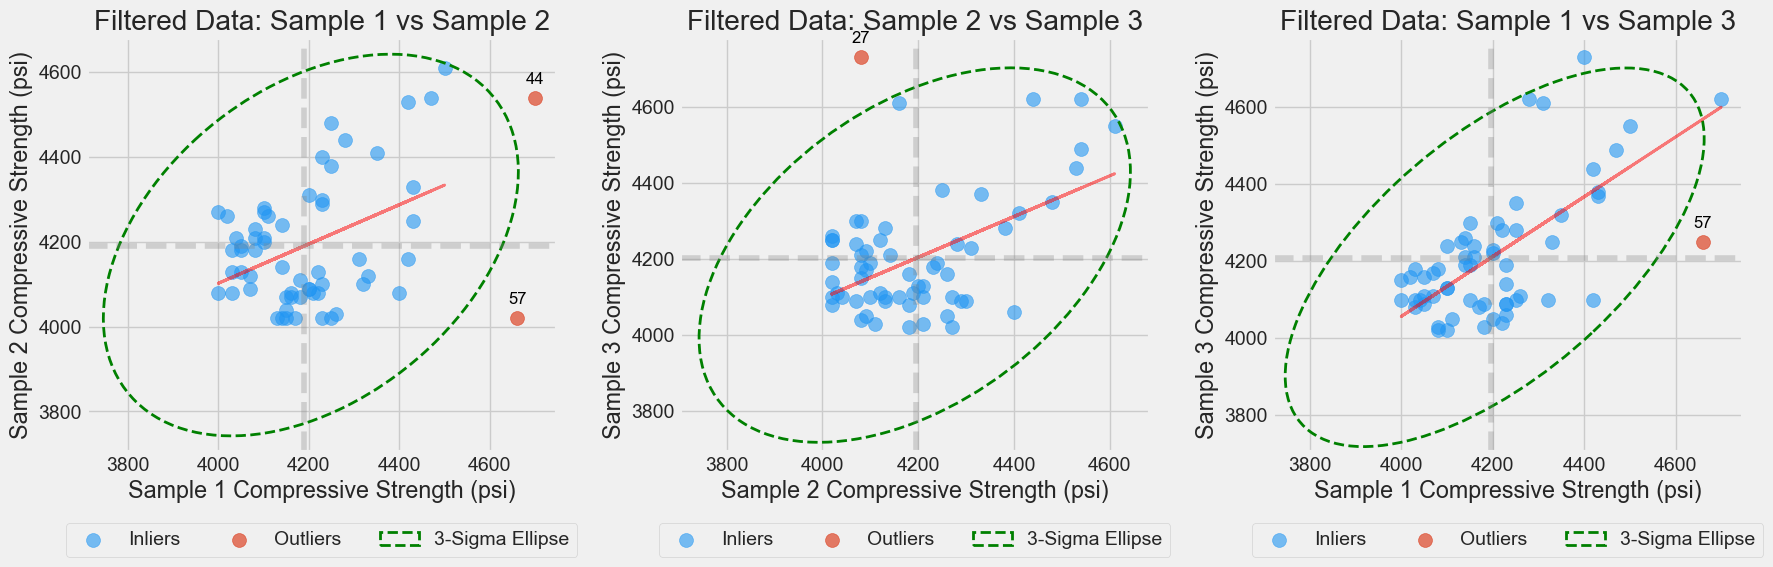

In [42]:
def create_filtered_plot(
    data: pd.DataFrame,
    inliers: pd.DataFrame,
    outliers: pd.DataFrame,
    sample_pairs: tuple[str, str],
    save_graph: bool = False,
    alpha: float = 0.05,
) -> None:
    """Creates a scatter plot of filtered data points with a 3-sigma ellipse.

    Args:
        data (pd.DataFrame): Original data points containing sample measurements
        inliers (pd.DataFrame): DataFrame containing the inlier data points
        outliers (pd.DataFrame): DataFrame containing the outlier data points
        sample_pairs (tuple[str, str]): Pair of sample columns to compare
        save_graph (bool, optional): Whether to save the plot. Defaults to False.
        alpha (float, optional): Significance level for the Mahalanobis filter. Defaults to 0.05.
    """
    # Set plot style and figure size
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(18, 6))

    sample1, sample2 = sample_pairs

    # Create subplot
    plt.subplot(1, 3, 1)

    # Fit Mahalanobis filter to calculate mean and covariance
    m_filter = MahalanobisFilter(alpha=alpha)
    m_filter.fit(data)

    # Plot inliers and outliers with distinct colors
    plt.scatter(
        inliers[sample1],
        inliers[sample2],
        color="#2196F3",
        alpha=0.6,
        s=100,
        label="Inliers",
    )
    plt.scatter(
        outliers[sample1],
        outliers[sample2],
        color="#D92906",
        alpha=0.6,
        s=100,
        label="Outliers",
    )

    # Annotate outliers with Pile No.
    for _, row in outliers.iterrows():
        plt.annotate(
            row["Pile No."],
            (row[sample1], row[sample2]),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
            fontsize=8,
            color="black",
        )

    # Add the 3-sigma confidence ellipse
    plot_ellipse(
        mean=m_filter.mean,
        cov=m_filter.cov,
        n_std=3,
        edgecolor="green",
        linestyle="--",
        linewidth=2,
        label="3-Sigma Ellipse",
    )

    # Calculate and plot regression line through inliers
    m, b = np.polyfit(inliers[sample1], inliers[sample2], 1)
    plt.plot(
        inliers[sample1],
        m * inliers[sample1] + b,
        color="red",
        linestyle="-",
        alpha=0.5,
        linewidth=2,
    )

    # Add mean reference lines
    mean_x = inliers[sample1].mean()
    mean_y = inliers[sample2].mean()
    plt.axvline(x=mean_x, color="gray", linestyle="--", alpha=0.3)
    plt.axhline(y=mean_y, color="gray", linestyle="--", alpha=0.3)

    # Add plot labels and legend
    plt.title(f"Filtered Data: {sample1} vs {sample2}")
    plt.xlabel(f"{sample1} Compressive Strength (psi)")
    plt.ylabel(f"{sample2} Compressive Strength (psi)")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)

    # Save plot if requested
    if save_graph:
        plt.savefig(
            f"images/filtered_data_3sigma_ellipse_{sample1}_{sample2}.png",
            dpi=300,
            bbox_inches="tight",
        )
    plt.tight_layout()
    plt.show()


def plot_sample_pairs(
    data: pd.DataFrame,
    sample_pairs: list[tuple[str, str]] | None = None,
    alpha: float = 0.05,
    save_graph: bool = False,
) -> None:
    """Plot filtered data for multiple sample pairs with Mahalanobis distance outlier detection.

    Args:
        data (pd.DataFrame): DataFrame containing the sample measurements
        sample_pairs (list[tuple[str, str]] | None): List of tuples containing sample pairs to analyze.
            Defaults to [("Sample 1", "Sample 2"), ("Sample 2", "Sample 3"), ("Sample 1", "Sample 3")]
        alpha (float): Significance level for outlier detection. Defaults to 0.05
    """
    # Set default sample pairs if none provided
    if sample_pairs is None:
        sample_pairs = [
            ("Sample 1", "Sample 2"),
            ("Sample 2", "Sample 3"),
            ("Sample 1", "Sample 3"),
        ]

    # Create figure with subplots
    plt.figure(figsize=(18, 6))

    # Process each sample pair
    for i, pair in enumerate(sample_pairs, 1):
        plt.subplot(1, 3, i)

        # Prepare and filter data
        processed_data = process_data(data, pair)
        filter_obj = MahalanobisFilter(alpha=alpha)
        filter_obj.fit(processed_data)
        inliers, outliers = filter_obj.filter(processed_data, margin=0.0)

        # Plot inliers and outliers
        plt.scatter(
            inliers[pair[0]],
            inliers[pair[1]],
            color="#2196F3",
            alpha=0.6,
            s=100,
            label="Inliers",
        )
        plt.scatter(
            outliers[pair[0]],
            outliers[pair[1]],
            color="#D92906",
            alpha=0.6,
            s=100,
            label="Outliers",
        )

        # Annotate outliers with Pile No.
        for _, row in outliers.iterrows():
            plt.annotate(
                row["Pile No."],
                (row[pair[0]], row[pair[1]]),
                textcoords="offset points",
                xytext=(0, 10),
                ha="center",
                fontsize=12,
                color="black",
            )

        # Add confidence ellipse
        plot_ellipse(
            mean=filter_obj.mean,
            cov=filter_obj.cov,
            n_std=3,
            edgecolor="green",
            linestyle="--",
            linewidth=2,
            label="3-Sigma Ellipse",
        )

        # Calculate and plot regression line
        m, b = np.polyfit(inliers[pair[0]], inliers[pair[1]], 1)
        plt.plot(
            inliers[pair[0]],
            m * inliers[pair[0]] + b,
            color="red",
            linestyle="-",
            alpha=0.5,
            linewidth=2,
        )

        # Add mean reference lines
        mean_x = inliers[pair[0]].mean()
        mean_y = inliers[pair[1]].mean()
        plt.axvline(x=mean_x, color="gray", linestyle="--", alpha=0.3)
        plt.axhline(y=mean_y, color="gray", linestyle="--", alpha=0.3)

        # Add plot labels and legend
        plt.title(f"Filtered Data: {pair[0]} vs {pair[1]}")
        plt.xlabel(f"{pair[0]} Compressive Strength (psi)")
        plt.ylabel(f"{pair[1]} Compressive Strength (psi)")
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)

    # Save image
    if save_graph:
        plt.savefig(
            f"images/combined_filtered_graph_{pair[0].lower()}_{pair[1].lower()}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.tight_layout()
    plt.show()


# Example usage
if __name__ == "__main__":
    plot_sample_pairs(df_sample, sample_pairs=None, save_graph=True)